In [128]:
# importing modules needed
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sklearn
import re
from nltk.corpus import stopwords
import warnings;
warnings.filterwarnings('ignore');
import torch
import time
from sklearn.neighbors import KNeighborsClassifier
import pickle

import os
from transformers import DistilBertTokenizer,DistilBertModel
from torch.utils.data import Dataset,DataLoader
from sklearn import naive_bayes, svm
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split,StratifiedKFold
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import log_loss,accuracy_score, classification_report
from sklearn.cluster import KMeans
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")




In [3]:
cur_dir = os.getcwd()
input_dir = '/home/gusmavko@GU.GU.SE/MovieScriptsParticipantsData/'
script_dir = '/home/gusmavko@GU.GU.SE/MovieScriptsParticipantsData/Scripts'

In [5]:
train_path = os.path.join(cur_dir,input_dir,'Train.csv')
test_path = os.path.join(cur_dir,input_dir,'Test.csv')

In [61]:
text_df = pd.read_csv('Train.csv')

In [63]:
text_df['text'] = [open(script_dir + os.sep + file, "r").read() for file in text_df['File_Name']]

In [64]:

def clean_text(text):
    tokenized_text = []
    sw = stopwords.words(('english'))
    # remove backslash-apostrophe 
    text = re.sub("\'", "", text) 
    # remove everything except alphabets 
    text = re.sub("[^a-zA-Z]"," ",text) 
    # remove whitespaces and convert to lowercase 
    text = ' '.join(text.split()).lower() 
    
    no_stopword_text = [word for word in text.split() if not word in sw]
     
    return ' '.join(no_stopword_text)

In [68]:
text_df['text'] = text_df['text'].apply(lambda x: clean_text(x))

In [69]:
text_df.head()

,File_Name,Labels,text,clean_text
0,file_2180.txt,8,crouching tiger hidden dragon wang hui ling ja...,crouching tiger hidden dragon wang hui ling ja...
1,file_693.txt,4,mumford screenplay lawrence kasdan shooting dr...,mumford screenplay lawrence kasdan shooting dr...
2,file_2469.txt,6,max payne written beau michael thorne black ma...,max payne written beau michael thorne black ma...
3,file_2542.txt,6,slumdog millionaire written simon beaufoy nove...,slumdog millionaire written simon beaufoy nove...
4,file_378.txt,16,b b window top top location href location href...,b b window top top location href location href...


In [82]:
# extracting tf-idf as features from the train set, which I split with test_size = 0.2
Train_X, Test_X, Train_Y, Test_Y = train_test_split(text_df['text'],text_df['Labels'],test_size=0.2)
vec = TfidfVectorizer(max_features=10000)
vec.fit(text_df['clean_text'])
Train_X_tdidf = vec.transform(Train_X)
Test_X_tfidf = vec.transform(Test_X)

In [83]:
# Classifier - Algorithm - SVM
# fit the training dataset on the classifier
SVM = svm.SVC(C=1.0, kernel='linear', degree=1, gamma='auto')
SVM.fit(Train_X_tdidf,Train_Y)
# predict the labels on validation dataset
predictions_SVM = SVM.predict(Test_X_tfidf)
accuracy_svm = accuracy_score(predictions_SVM, Test_Y)
# Use accuracy_score function to get the accuracy
print("SVM Accuracy Score -> ", accuracy_svm)

SVM Accuracy Score ->  0.10858585858585859


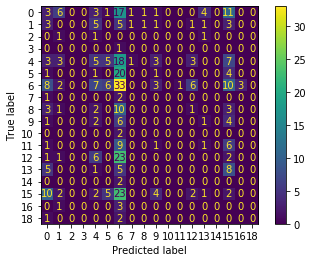

In [110]:
sklearn.metrics.plot_confusion_matrix(SVM,Test_X_tfidf,Test_Y)

In [85]:
# trying out with Naive Bayes too
Naive = naive_bayes.MultinomialNB()
Naive.fit(Train_X_tdidf,Train_Y)

predictions_NB = Naive.predict(Test_X_tfidf)
# Use accuracy_score function to get the accuracy
nvb_accuracy = accuracy_score(predictions_NB, Test_Y)
print("Naive Bayes Accuracy Score -> ", nvb_accuracy)

Naive Bayes Accuracy Score ->  0.19444444444444445


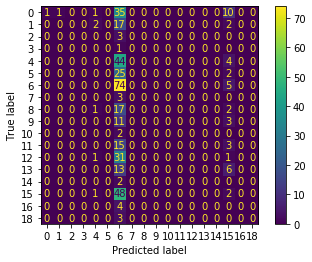

In [111]:
sklearn.metrics.plot_confusion_matrix(Naive,Test_X_tfidf,Test_Y)

In [98]:
# number of neighbors set to 5 after cross validating the data
kn = KNeighborsClassifier(5)
kn.fit(Train_X_tdidf,Train_Y)
predictions_KN = kn.predict(Test_X_tfidf)
kn_accuracy = accuracy_score(predictions_KN,Test_Y)
print("K Neighbors Accuracy Score -> ", kn_accuracy)

K Neighbors Accuracy Score ->  0.11363636363636363


In [101]:
# fit model no training data
from xgboost import XGBClassifier
xgb = XGBClassifier()
xgb.fit(Train_X_tdidf, Train_Y)

# make predictions for test data

predictions_xgb = xgb.predict(Test_X_tfidf)
predictions = [round(value) for value in predictions_xgb]

# evaluate predictions

xgb_accuracy = accuracy_score(Test_Y, predictions)
print("Accuracy: %.2f%%" % (xgb_accuracy))

Accuracy: 0.08%


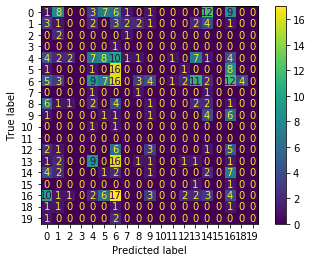

In [109]:
sklearn.metrics.plot_confusion_matrix(xgb,Test_X_tfidf,Test_Y)

In [113]:
from sentence_transformers import SentenceTransformer
model = SentenceTransformer('distilbert-base-nli-stsb-mean-tokens')
sentences = list(text_df['text'])
sentence_embeddings = model.encode(sentences)
print("sentence embeddings with bert created")

sentence embeddings with bert created


In [124]:
# save to be able to reuse later 
with open('/home/gusmavko@GU.GU.SE/MovieScriptsParticipantsData/sent_bert_embeddings.pickle', 'wb') as handle:
    pickle.dump(sentence_embeddings, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
# trying to see if accuracy imporves with sentence embeddings
sentence_embeddings_df = pd.DataFrame(sentence_embeddings)
X_train, X_test, y_train, y_test = train_test_split(sentence_embeddings_df, text_df[['Labels']], test_size=0.2, random_state = 123)

nb = Pipeline([('clf', GaussianNB()),])
nb.fit(X_train, y_train)


y_pred = nb.predict(X_test)

print('accuracy %s' % accuracy_score(y_pred, y_test))


accuracy 0.11363636363636363


In [127]:

sgd = Pipeline([('clf', SGDClassifier(loss='hinge', penalty='l2',alpha=1e-3, random_state=123, max_iter=5, tol=None)),])
sgd.fit(X_train, y_train)

y_pred = sgd.predict(X_test)

print('accuracy %s' % accuracy_score(y_pred, y_test))


accuracy 0.15656565656565657


In [6]:
df_raw = pd.read_csv(train_path)

In [7]:
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
model = DistilBertModel.from_pretrained('distilbert-base-uncased')


In [8]:
def script_reader(file_name):
    script_path = os.path.join(cur_dir,script_dir,file_name)
    with open (script_path, "r") as myfile:
        script =  myfile.read()
        return script

In [9]:
# since the scripts are so long, I had to feed the model sequences of 512 length 
class ScriptDataset(Dataset):
    def __init__(self, file_path,tokenizer,seq_len = 510):
        #Sequence length = Maximum possible sequence length(512) which can be fed to model - start and end tokens(2) 
        self.file_path =  file_path
        self.script = script_reader(self.file_path)
        #Each script is loaded only when it is being processed and deleted once tokenization and encoding is done
        self.tokenizer = tokenizer
        self.seq_len = seq_len
        self.tokens = self.tokenizer.tokenize(self.script)
        del self.script
        self.sequences = [self.tokens[i:i+self.seq_len] for i in range(0,len(self.tokens),self.seq_len)][:-1]
        #Drops last sequence of unequal length
        del self.tokens
        
    def __len__(self):
        return len(self.sequences) 
    
    def __getitem__(self, idx):
        return torch.tensor(self.tokenizer.encode(self.sequences[idx], add_special_tokens=True))

In [10]:
def create_bert_embedding(file_path,tokenizer,model,batch_size = 2):
    model = model.to(device)
    model = model.eval()
    
    script_set = ScriptDataset(file_path,tokenizer)
    batch_loader = DataLoader(script_set,batch_size = batch_size, shuffle = False,drop_last=False)
    del script_set
    
    seq_embeddings = []
    for i,batch in enumerate(batch_loader):
        batch = batch.to(device)
        #Avoid gradient calculation , for speed and memory issues
        with torch.no_grad():
            seq_embed = model(batch)[0][:,0,:]
            #Collecting only the final hidden state corresponding to CLS token which can be used as sequence embedding(imperfect but still works)
        del batch
        seq_embeddings.append(seq_embed)
        del seq_embed
    del batch_loader
           
    return torch.cat(seq_embeddings,dim = 0).cpu().detach().numpy()

In [11]:
tik = time.time()
Embeddings = []
for i in range(len(df_raw)):
    Embeddings.append(create_bert_embedding(df_raw.File_Name[i],tokenizer,model))
    if i % 50 == 0:
        print(i)



0
50
100
150
200
250
300
350
400
450
500
550
600
650
700
750
800
850
900
950
1000
1050
1100
1150
1200
1250
1300
1350
1400
1450
1500
1550
1600
1650
1700
1750
1800
1850
1900
1950


In [15]:
with open('/home/gusmavko@GU.GU.SE/MovieScriptsParticipantsData/s_embeddings.pickle', 'wb') as handle:
    pickle.dump(Embeddings, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
df_raw['Embeds'] = Embeddings
tok = time.time()
print (f'{round(tok-tik,2)}s')

with open('/home/gusmavko@GU.GU.SE/MovieScriptsParticipantsData/df_raw_embeds.pickle', 'wb') as handle:
    pickle.dump(df_raw, handle, protocol=pickle.HIGHEST_PROTOCOL)

    


#Saving the embeddings in the drive incase the colab session gets terminated 
print('Pickling completed')


#Saving the dataframe so that further analysis can start from this point

2497.85s
Pickling completed


In [34]:
# to be able to start from here by loading pickled file whenever I want to process it
df_embed_path = '/home/gusmavko@GU.GU.SE/MovieScriptsParticipantsData/df_raw_embeds.pickle'

with open(df_embed_path, 'rb') as handle:
    df_raw = pickle.load(handle)


In [43]:
df_raw.Labels.unique()

array([ 8,  4,  6, 16, 15, 19,  1, 14,  0,  5,  7, 11])

In [44]:
# merge labels that appear less than 20 times with labels that are frequently occuring
#df_raw=df_raw.Labels.replace(dict.fromkeys([9,20,21], 8))
#df_raw=df_raw.Labels.replace(dict.fromkeys([3,10,12,13], 15))
##df_raw=df_raw.replace(dict.fromkeys([21], 8))
#df_raw=df_raw.Labels.replace(dict.fromkeys([2], 7))
#df_raw=df_raw.Labels.replace(dict.fromkeys([18,17], 1))
replacements = {9:8,21:8,20:8,3:15,10:15,12:15,13:15,2:7,18:1,17:1}
df_raw['Labels'] =df_raw['Labels'].replace(replacements)

#relabel the integers from 1-12

In [45]:
#Do kfold cross validation to get accuracy scores
df_raw["kfold"] = -1
skf = StratifiedKFold()
for fold, (train_idx, val_idx) in enumerate(skf.split(X=df_raw, y=df_raw['Labels'].values)):
                    df_raw.loc[val_idx, 'kfold'] = fold
        

In [46]:
# make new data frame with arrays that contain the features as values
def create_df_embeds(feat_array, df):
    cols_num = feat_array[0].shape[0]
    col_names = ['feat_' + str(i+1) for i in range(cols_num)]
    df_feat = pd.DataFrame(data = feat_array,columns = col_names)
    df_fit = pd.concat([df, df_feat], axis=1)
    return df_fit,col_names

In [130]:
# training function
def train(df_fit,classifier,feat_cols,label_col = 'Labels'):
    
    folds = df_fit.kfold.nunique()
    FOLD_MAPPPING = {fold:list(set(range(folds)) - set([fold]))  for fold in range(folds)}
    clfs = [classifier]*folds
    
    train_losses = []
    train_accuracies = []
    valid_losses = []
    valid_accuracies = []
    
    for FOLD in range(5):
        
        train_df = df_fit[df_fit.kfold.isin(FOLD_MAPPPING.get(FOLD))].reset_index(drop=True)
        valid_df = df_fit[df_fit.kfold==FOLD].reset_index(drop=True)
        
        clf = clfs[FOLD]
        clf.fit(train_df[feat_cols].values, train_df[label_col])
        
        train_probs = clf.predict_proba(train_df[feat_cols].values)
        train_preds = clf.predict(train_df[feat_cols].values)
        
        train_accuracy = accuracy_score(train_df[label_col], train_preds)
        train_loss = log_loss(train_df[label_col], train_probs)
        
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)

        valid_probs = clf.predict_proba(valid_df[feat_cols].values)
        valid_preds = clf.predict(valid_df[feat_cols].values)
        
        valid_accuracy = accuracy_score(valid_df[label_col], valid_preds)
        valid_loss = log_loss(valid_df[label_col], valid_probs)
        
        valid_losses.append(valid_loss)
        valid_accuracies.append(valid_accuracy)
        
    mean_train_loss,std_train_loss = np.mean(train_losses),np.std(train_losses)
    mean_train_accuracy,std_train_accuracy  = np.mean(train_accuracies),np.std(train_accuracies)

    mean_valid_loss,std_valid_loss = np.mean(valid_losses),np.std(valid_losses)
    mean_valid_accuracy,std_valid_accuracy  = np.mean(valid_accuracies),np.std(valid_accuracies)

    print(f'train loss = {mean_train_loss} with {np.round((std_train_loss/mean_train_loss)*100, 2)}% error')
    print(f'valid loss = {mean_valid_loss} with {np.round((std_valid_loss/mean_valid_loss)*100, 2)}% error')

    print(f'train accuracy = {mean_train_accuracy} with {np.round((std_train_accuracy/mean_train_accuracy)*100, 2)}% error')
    print(f'valid accuracy = {mean_valid_accuracy} with {np.round((std_valid_accuracy/mean_valid_accuracy)*100, 2)}% error')
    
    return clfs

In [131]:
# calculate accuracy

seed = 123
#Fixing seed to ensure reproducibility
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
np.random.seed(seed)

mean_array = np.stack((df_raw.Embeds.apply(lambda x: x.mean(axis = 0)).values),axis = 0)
df_mean,cols = create_df_embeds(mean_array, df_raw)
classif = LogisticRegression(random_state=seed)
LR_clfs = train(df_mean,classif,cols)

train loss = 1.5825258179052943 with 0.65% error
valid loss = 1.989822084801452 with 0.56% error
train accuracy = 0.39686507958691947 with 1.07% error
valid accuracy = 0.24925073520010232 with 6.85% error


In [ ]:
from sklearn.metrics import classification_report
import sklearn
from sklearn.model_selection import train_test_split

from sklearn.feature_extraction.text import TfidfVectorizer

import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

X_train, X_test, Y_train, Y_test = train_test_split(data['clean_text'],data['Labels'],test_size=0.3)
Tfidf_vect = TfidfVectorizer(max_features=5000,max_df=0.5,min_df=5)
Tfidf_vect.fit(data['clean_text'])
Train_X_Tfidf = Tfidf_vect.transform(Train_X)
Test_X_Tfidf = Tfidf_vect.transform(Test_X)